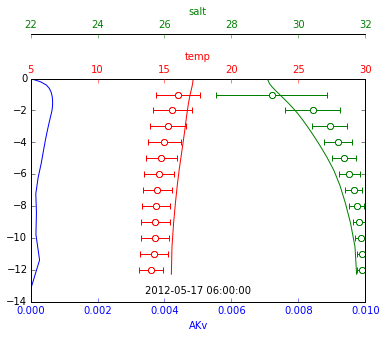

In [9]:
# (c) 2015 Teruhisa Okada

% matplotlib inline

import matplotlib.pyplot as plt
import netCDF4
from datetime import datetime
import numpy as np
import pandas as pd

import romspy

stafile = 'Z:/roms/Apps/OB500_fennelP/NL12/ob500_avg.nc'
obsfile = 'F:/okada/Dropbox/Data/ob500_obs_2012_obweb-4.nc'
stations = 'F:/okada/Dropbox/Data/stations13.csv'

nc = netCDF4.Dataset(stafile, 'r')
obs = netCDF4.Dataset(obsfile, 'r')


def station2xy(station):
    df = pd.read_csv(stations)
    x = df.xgrid[station-1]
    y = df.ygrid[station-1]
    return x-1, y-1

def vplot(month, station):
    mod_time = nc.variables['ocean_time'][:]
    mod_time = netCDF4.num2date(mod_time, romspy.JST)
    t = np.where(np.asarray([t.month for t in mod_time])==month)[0][0]
    x, y = station2xy(station)
    akv = nc.variables['AKv'][t,:,y,x]
    rho = nc.variables['rho'][t,:,y,x]
    temp = nc.variables['temp'][t,:,y,x]
    salt = nc.variables['salt'][t,:,y,x]
    chlo = nc.variables['chlorophyll'][t,:,y,x]
    DO = nc.variables['oxygen'][t,:,y,x]
    cs_r = nc.variables['Cs_r'][:]
    cs_w = nc.variables['Cs_w'][:]
    h = nc.variables['h'][y,x]
    zeta = nc.variables['zeta'][t,y,x]
    depth = cs_r[:] * (h + zeta)
    depth_w = cs_w[:] * (h + zeta)
    
    """fig, ax = plt.subplots(1, 2, figsize=[12,4])
    axes = [ax[0], ax[0].twiny(), ax[0].twiny()]
    axes1 = [ax[1], ax[1].twiny()]"""
    fig, ax = plt.subplots(1, 1, figsize=[6,4])
    axes = [ax, ax.twiny(), ax.twiny()]
    
    #fig.subplots_adjust(right=0.75)
    axes[-1].spines['top'].set_position(('axes', 1.2))
    axes[-1].set_frame_on(True)
    axes[-1].patch.set_visible(False)

    axes[0].plot(akv, depth_w, 'b-')
    axes[0].set_xlabel('AKv', color='b')
    axes[0].tick_params(axis='x', colors='b')
    axes[0].set_xlim(0,0.01)
    
    axes[1].plot(temp, depth, 'r-')
    axes[1].set_xlabel('temp', color='r')
    axes[1].tick_params(axis='x', colors='r')
    axes[1].set_xlim(5,30)
    #axes[1].plot(rho, depth, 'r-')
    #axes[1].set_xlabel('rho', color='r')
    #axes[1].tick_params(axis='x', colors='r')
    #axes[1].set_xlim(15,25)
    
    axes[2].plot(salt, depth, 'g-')
    axes[2].set_xlabel('salt', color='g')
    axes[2].tick_params(axis='x', colors='g')
    axes[2].set_xlim(22,32)

    """axes1[0].plot(chlo, depth, 'b-')
    axes1[0].set_xlabel('chlorophyll', color='b')
    axes1[0].tick_params(axis='x', colors='b')
    axes1[0].set_xlim(0,20.0)
    
    axes1[1].plot(DO, depth, 'r-')
    axes1[1].set_xlabel('DO', color='r')
    axes1[1].tick_params(axis='x', colors='r')
    axes1[1].set_xlim(0,300.0)"""
    
    axes[2].text(27, -13.5, datetime.strftime(mod_time[t], '%Y-%m-%d %H:%M:%S'), ha='center')
    
    start = netCDF4.date2num(datetime(2012,month,1,0), romspy.JST_days)
    if month == 12:
        end = netCDF4.date2num(datetime(2013,1,1,0), romspy.JST_days)
    else:
        end = netCDF4.date2num(datetime(2012,month+1,1,0), romspy.JST_days)
    obs_time = obs.variables['obs_time'][:]
    obs_station = obs.variables['obs_station'][:]
    index = np.where((start<=obs_time) & (obs_time<end) & (obs_station==station))[0]
    if len(index) > 0:
        obs_type = obs.variables['obs_type'][index]
        obs_depth = obs.variables['obs_depth'][index]
        obs_value = obs.variables['obs_value'][index]
        data={'time':obs_time[index], 'depth':obs_depth, 'type':obs_type, 'value':obs_value}
        df = pd.DataFrame(data)
        varid = {'temp':6, 'salt':7, 'chlorophyll':10, 'oxygen':15}
        for d in range(0, -15, -1):
            df2 = df[df.depth==float(d)]
            temp = df2[df2.type==varid['temp']]
            salt = df2[df2.type==varid['salt']]
            chlo = df2[df2.type==varid['chlorophyll']]
            DO = df2[df2.type==varid['oxygen']]
            axes[1].errorbar(temp.value.mean(), d, xerr=temp.value.std(), fmt='o', ecolor='r', mec='r', mfc='w', mew=1)
            axes[2].errorbar(salt.value.mean(), d, xerr=salt.value.std(), fmt='o', ecolor='g', mec='g', mfc='w', mew=1)
            """axes1[0].errorbar(chlo.value.mean(), d, xerr=chlo.value.std(), fmt='o', ecolor='b', mec='b', mfc='w', mew=1)
            axes1[1].errorbar(DO.value.mean(), d, xerr=DO.value.std(), fmt='o', ecolor='r', mec='r', mfc='w', mew=1)"""
    
vplot(5, 12)
plt.savefig('profile_obs_avg_AKv.png', bbox_inches='tight', dpi=300)